# Inference of parameters (SI2R model)
In this notebook, we consider the S2IR model with presimptomatically, symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_p}$ (rate of recovery for presymptomatic infected individuals),
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given the full data (of classes S, Ip, Ia, Is) from a generated trajectory.


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [2]:
M = 2                # the population has two age groups
N = 1e6              # and this is the total population

# parameters for generating synthetic trajectory 
beta  = 0.02         # infection rate
gIp   = 1./7         # recovery rate of presymptomatic infectives
gIa   = 1./7         # recovery rate of asymptomatic infectives
gIs   = 1./7         # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 1            # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], 
              [3., 12.]]) 
# C_ij = number of people group from group i that an individual from group j meets per day 

# set up initial condition
Ip0 = np.array([10, 10])  # each age group has asymptomatic infectives
Ia0 = np.array([5, 5])  # each age group has asymptomatic infectives
Is0 = np.array([2, 2])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Ip0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIp':gIp, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIp':gIp, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SI2R(parameters, M, Ni)
data = sto_model.simulate(S0, Ip0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau-leaping')
data_array = data['X']
np.save('SI2R_sto_traj.npy', data_array)

In [3]:
data

{'X': array([[249983, 749983,     10,     10,      5,      5,      2,      2],
        [249973, 749973,     18,     16,      5,      7,      3,      4],
        [249960, 749964,     27,     20,      6,      9,      4,      6],
        [249934, 749943,     52,     38,      5,      7,      5,      9],
        [249904, 749915,     72,     59,      7,      6,     10,     13],
        [249869, 749874,     95,     90,      7,      8,     20,     19],
        [249816, 749798,    125,    146,     10,     12,     35,     33],
        [249725, 749691,    192,    230,     14,      9,     49,     49],
        [249605, 749554,    270,    332,     23,     17,     68,     66],
        [249399, 749321,    423,    508,     31,     29,     98,     97],
        [249089, 748986,    662,    755,     39,     48,    137,    149],
        [248640, 748544,    985,   1066,     53,     75,    205,    219],
        [248018, 747868,   1443,   1557,     77,     91,    309,    335],
        [247105, 746856,   2086, 

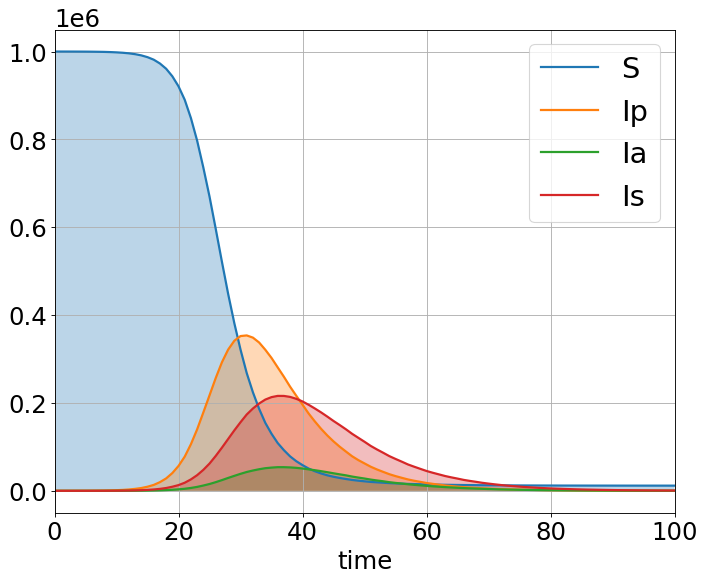

In [4]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ip', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Ia', lw=2)

plt.fill_between(t, 0, np.sum(data_array[:, 3*M:4*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-', label='Is', lw=2)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

## 2) Inference
We take the first $20$ data points of the trajectories and use it to infer the parameters of the model.

In [5]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = np.load('SI2R_sto_traj.npy').astype('float')
x = (x)[:Nf_inference]

estimator = pyross.inference.SI2R(parameters, M, Ni)

In [6]:
Ni

array([250000., 750000.])

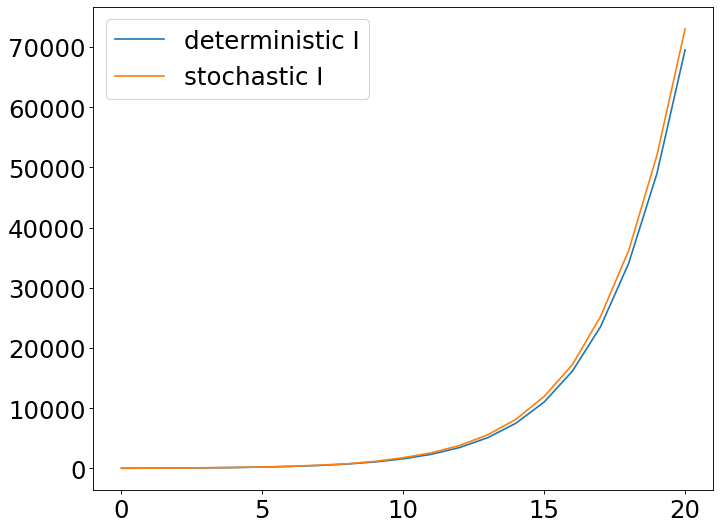

In [7]:
# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
x0=x[0]
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
xm = estimator.integrate(x[0], 0, Tf_inference, Nf_inference)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(xm[:, M:], axis=1), label='deterministic I')
plt.plot(np.sum(x[:Nf_inference, M:], axis=1), label='stochastic I')
plt.legend()
plt.show()

In [8]:
xm

array([[2.49983000e+05, 7.49983000e+05, 1.00000000e+01, 1.00000000e+01,
        5.00000000e+00, 5.00000000e+00, 2.00000000e+00, 2.00000000e+00],
       [2.49974375e+05, 7.49974374e+05, 1.67408647e+01, 1.67413650e+01,
        4.68769337e+00, 4.68769931e+00, 3.14688243e+00, 3.14690619e+00],
       [2.49961836e+05, 7.49961834e+05, 2.62487046e+01, 2.62503239e+01,
        4.63151197e+00, 4.63154376e+00, 4.99936743e+00, 4.99949456e+00],
       [2.49943477e+05, 7.49943472e+05, 3.99408838e+01, 3.99449775e+01,
        4.88914700e+00, 4.88924713e+00, 7.83061560e+00, 7.83101610e+00],
       [2.49916487e+05, 7.49916476e+05, 5.98896847e+01, 5.98992144e+01,
        5.55683050e+00, 5.55709110e+00, 1.20623380e+01, 1.20633804e+01],
       [2.49876733e+05, 7.49876708e+05, 8.91324920e+01, 8.91539152e+01,
        6.78534558e+00, 6.78596712e+00, 1.83295839e+01, 1.83320701e+01],
       [2.49818116e+05, 7.49818060e+05, 1.32139778e+02, 1.32187192e+02,
        8.80475397e+00, 8.80617421e+00, 2.75802663e+01, 2.

In [9]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIp':gIp, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use faster ODE methods to speed up inference 
estimator.set_lyapunov_method('euler')
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, contactMatrix, tangent=False)
end_time = time.time()
print(logp) 
print(end_time - start_time)

578.140668293632
0.024792909622192383


In [10]:
# compare to tangent space 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIp':gIp, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

632.4019954556749
0.0038330554962158203


In [11]:
# Define the prior (log normal prior around guess of parameter with defined std. deviation)
alpha_g = 0.25
beta_g = 0.04
gIp_g = 0.1
gIa_g = 0.1
gIs_g = 0.1


# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIp':gIp_g, 'gIa':gIa_g, 'gIs':gIs_g, 'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, contactMatrix)
print(logp) 

28152.668842672807


In [12]:
# Set up priors 
eps = 1e-4
priors = {
    'alpha':{
        'mean': alpha_g, 
        'std': 0.2, 
        'bounds': [eps, 0.8], 
        'prior_fun': 'truncnorm'
    }, 
    'beta':{
        'mean': beta_g, 
        'std': 0.1, 
        'bounds': [eps, 0.2], 
        'prior_fun': 'lognorm'
    }, 
    'gIp':{
        'mean': gIa_g, 
        'std': 0.2, 
        'bounds': [eps, 0.6]
    }, 
    'gIa':{
        'mean': gIa_g, 
        'std': 0.2, 
        'bounds': [eps, 0.6]
    }, 
    'gIs':{
        'mean': gIs_g, 
        'std': 0.2, 
        'bounds': [eps, 0.6]
    }
}

# Stopping criterion for minimisation (realtive change in function value)
ftol = 1e-6  
start_time = time.time() 
res = estimator.infer_parameters(x, Tf_inference, contactMatrix, priors, tangent=False, 
                                    global_max_iter=20, local_max_iter=400,
                                    cma_population=32, global_atol=10,
                                    ftol=ftol, verbose=True)
end_time = time.time()

print(res['map_dict']) # best guess 
print(end_time - start_time)

Starting global minimisation ...
(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 5 (seed=538417023, Tue Mar  7 14:32:09 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     32 2.750056617543635e+03 1.0e+00 8.73e-01  5e-02  2e-01 0:00.4
    2     64 2.944756638925679e+03 1.4e+00 1.03e+00  5e-02  2e-01 0:00.8
    3     96 2.081096917400006e+03 1.8e+00 9.24e-01  4e-02  2e-01 0:01.1
   13    416 6.080959946171877e+02 9.4e+00 2.74e-01  2e-03  5e-02 0:04.1
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  572.925224033514
Starting local minimisation...
Optimal value (local minimisation):  569.5386545066428
{'alpha': 0.21785756054867952, 'beta': 0.019896711392379016, 'gIp': 0.14348205428823896, 'gIa': 0.17243507329925145, 'gIs': 0.1320876906724977, 'fsa': array([1., 1.])}
8.915549278259277


In [13]:
# compute log_p for best estimate 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(res['map_dict'], x, Tf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

573.9615204923186
0.020375967025756836


In [14]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(res['map_dict'])

print(res['flat_map'])

True parameters:
{'alpha': 0.2, 'beta': 0.02, 'gIp': 0.14285714285714285, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

Inferred parameters:
{'alpha': 0.21785756054867952, 'beta': 0.019896711392379016, 'gIp': 0.14348205428823896, 'gIa': 0.17243507329925145, 'gIs': 0.1320876906724977, 'fsa': array([1., 1.])}
[0.21785756 0.01989671 0.14348205 0.17243507 0.13208769]


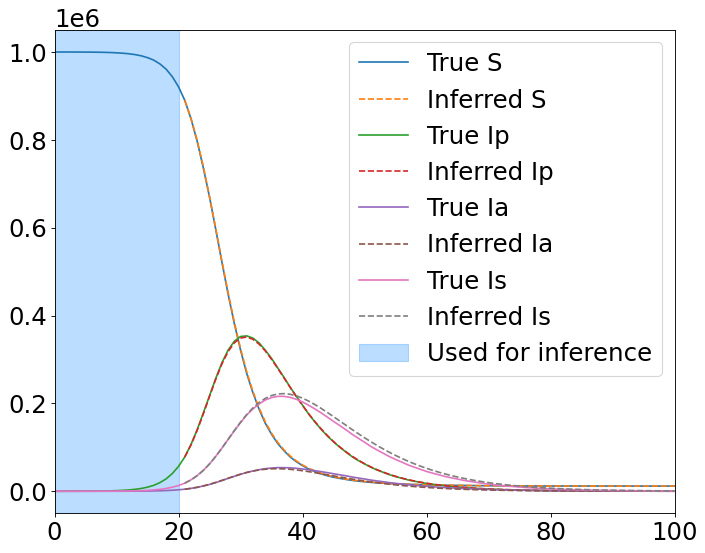

In [15]:
x = np.load('SI2R_sto_traj.npy').astype('float')
Nf = x.shape[0]
Tf = Nf-1

# set the deterministic method to be solve_ivp for accurate integration over long time scale 
estimator.set_det_model(res['map_dict'])
estimator.set_params(res['map_dict'])

x_det = estimator.integrate(x[Nf_inference], Nf_inference, Tf, Nf-Nf_inference)
t_inf = np.linspace(Nf_inference, Tf, Nf-Nf_inference)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(t_inf, np.sum(x_det[:, :M], axis=1), '--', label='Inferred S')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ip')
plt.plot(t_inf, np.sum(x_det[:, M:2*M], axis=1), '--', label='Inferred Ip')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Ia')
plt.plot(t_inf, np.sum(x_det[:, 2*M:3*M], axis=1), '--', label='Inferred Ia')
plt.plot(np.sum(x[:, 3*M:4*M], axis=1), label='True Is')
plt.plot(t_inf, np.sum(x_det[:, 3*M:4*M], axis=1), '--', label='Inferred Is')

plt.xlim([0, Tf])
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 

In [16]:
eps = 1e-3
x = np.load('SI2R_sto_traj.npy').astype('float')[:Nf_inference]
hess = estimator.hessian(x, Tf_inference, res, contactMatrix=contactMatrix, eps=eps, tangent=False,
                                 fd_method="central")

epsilon used for differentiation:  0.001


In [17]:
cov = np.linalg.inv(hess)
print(cov)
v, w = np.linalg.eig(cov)
print(v)

[[ 1.50996548e-03  2.13484458e-10 -9.10052764e-07  3.69086784e-03
  -9.55561654e-04]
 [ 2.13484458e-10  4.05855559e-09 -2.75511015e-09  1.75224639e-09
   1.80325698e-09]
 [-9.10052764e-07 -2.75511015e-09  8.95003738e-07 -2.31942055e-06
   5.22268919e-07]
 [ 3.69086784e-03  1.75224639e-09 -2.31942055e-06  9.08421348e-03
  -2.34706934e-03]
 [-9.55561654e-04  1.80325698e-09  5.22268919e-07 -2.34706934e-03
   6.11258697e-04]]
[1.11921918e-02 9.09155778e-06 4.15646085e-06 8.92894507e-07
 4.04917340e-09]


## From here onwards,  still work in process (need to update Forecast module)

In [18]:
parameters = res['map_dict'].copy() 
parameters['fsa'] = fsa
parameters['cov'] = cov 

# Initialise pyross forecast module
model_forecast = pyross.forecast.SI2R(parameters, M, Ni)



In [23]:
# Initial condition for forecast is last configuration from inference-trajectory
S0_forecast = x[Tf_inference,:M]
Ip0_forecast = x[Tf_inference,M:2*M]
Ia0_forecast = x[Tf_inference,2*M:3*M]
Is0_forecast = x[Tf_inference,3*M:]
print(Ip0_forecast, Ia0_forecast, Is0_forecast)

# Number of simulations over which we average, use 500
Ns = 1000

Tf_forecast = Tf - Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(S0_forecast, Ip0_forecast, Ia0_forecast, Is0_forecast, 
                                          contactMatrix, Tf_forecast, Nf_forecast,
                                          verbose=True, method='deterministic',
                                          Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] + Tf_inference

[26866. 29741.] [1607. 1741.] [6092. 6908.]
Finished. Time needed for evaluation: 00:00:01


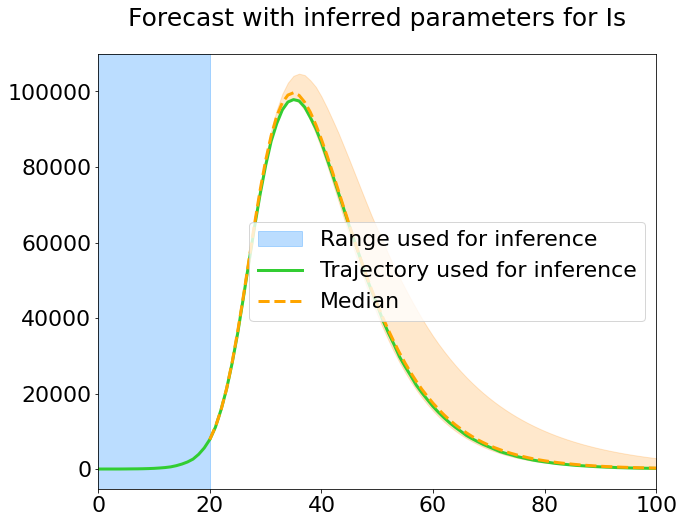

In [24]:
fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = trajectories_forecast[:,5] + trajectories_forecast[:,6]
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)

cur_trajectory_underlying = data_array[:,5] + data_array[:,6]

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters for Is',
             y=1.05,
            fontsize=fontsize)
# for i,e in enumerate(cur_trajectories_forecast):
#     ax.plot(t_forecast,e,
#             alpha=0.15,
#            )

ax.fill_between(t_forecast, percentiles_lower, percentiles_upper, color='darkorange', alpha=0.2)
ax.plot(cur_trajectory_underlying,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
plt.legend()
plt.xlim([0, Tf])
plt.show()